In [13]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
from matplotlib import ticker

plt.rcParams["font.family"] = "Times New Roman"

In [14]:
def plot_power_flow_rate_curve(model, **kwargs):
    powers = np.linspace(model.min_power, model.max_power, 100)
    flow_rates_pump = np.zeros_like(powers)
    pressures_pump = np.zeros_like(powers)
    efficiencies = np.zeros_like(powers)

    pipeline_values = []
    
    for j, pipeline in enumerate(model.pipelines):
        pipeline_values.append((pipeline, [], [], []))
    
    for i, power in enumerate(powers):
        model.power = power
        model.optimize_flow_rates(**kwargs)
        flow_rates_pump[i] = model.flow_rate_pump()*1000
        efficiencies[i] = model.efficiency()*100
        pressures_pump[i] = model.p_pump()/100000

        for j, pipeline in enumerate(model.pipelines):
            pipeline_values[j][1].append(pipeline.flow_rate*1000)  
            pipeline_values[j][2].append(pipeline.p_res(model.fluid_density)/100000)  
            pipeline_values[j][3].append(pipeline.p_stat(model.fluid_density, model.gravity)/100000)  
        
    # scale values
    powers /= 1000
        
    # plot
    fig = plt.figure(figsize=(10, 10), dpi=300)
    gs = fig.add_gridspec(4, hspace=0.2, height_ratios=[2, 1, 1, 1])
    axs = gs.subplots(sharex=True)
    
    fig.suptitle(f"{model.name} (g: {model.gravity}$m/s^2$, density: {model.fluid_density}kg/$m^3$)", y=0.92)
    fig.supxlabel('Electrical Power', y=0.06)
    
    axs[0].plot(powers, flow_rates_pump, color="red", label=f"Pump")

    for i, pipeline in enumerate(pipeline_values):
        pipe_label = f"{pipeline[0].name} (L={pipeline[0].pipe_length}, A={pipeline[0].pipe_area}$m^2$, H={pipeline[0].height}m, drag: {pipeline[0].drag_coefficient})"
        
        axs[0].plot(powers, pipeline[1], label=pipe_label, linestyle="--")
        axs[1].plot(powers, pipeline[2], label=pipe_label, linestyle="--")

    axs[0].set_ylabel('Flow Rate')
    axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f [$L/s$]"))
    axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f} kW"))
    axs[0].axhline(0, color="k")
    axs[0].legend(loc="lower right", prop={'size': 8})
    axs[0].grid()

    axs[1].set_ylabel('$P_{res}$')
    axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f bar"))
    axs[1].legend(loc="lower right", prop={'size': 8})
    axs[1].grid()

    axs[2].set_ylabel('$P_{pump}$')
    axs[2].plot(powers, pressures_pump, color="red", label=f"Pump")
    axs[2].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f bar"))
    axs[2].legend(loc="lower right", prop={'size': 8})
    axs[2].grid()

    axs[3].fill_between(powers, efficiencies, 0)
    axs[3].set_ylabel('System Efficiency')  
    axs[3].yaxis.set_major_formatter(ticker.PercentFormatter())
    axs[3].set_ylim(0, 100)
    axs[3].grid()

    plt.show()

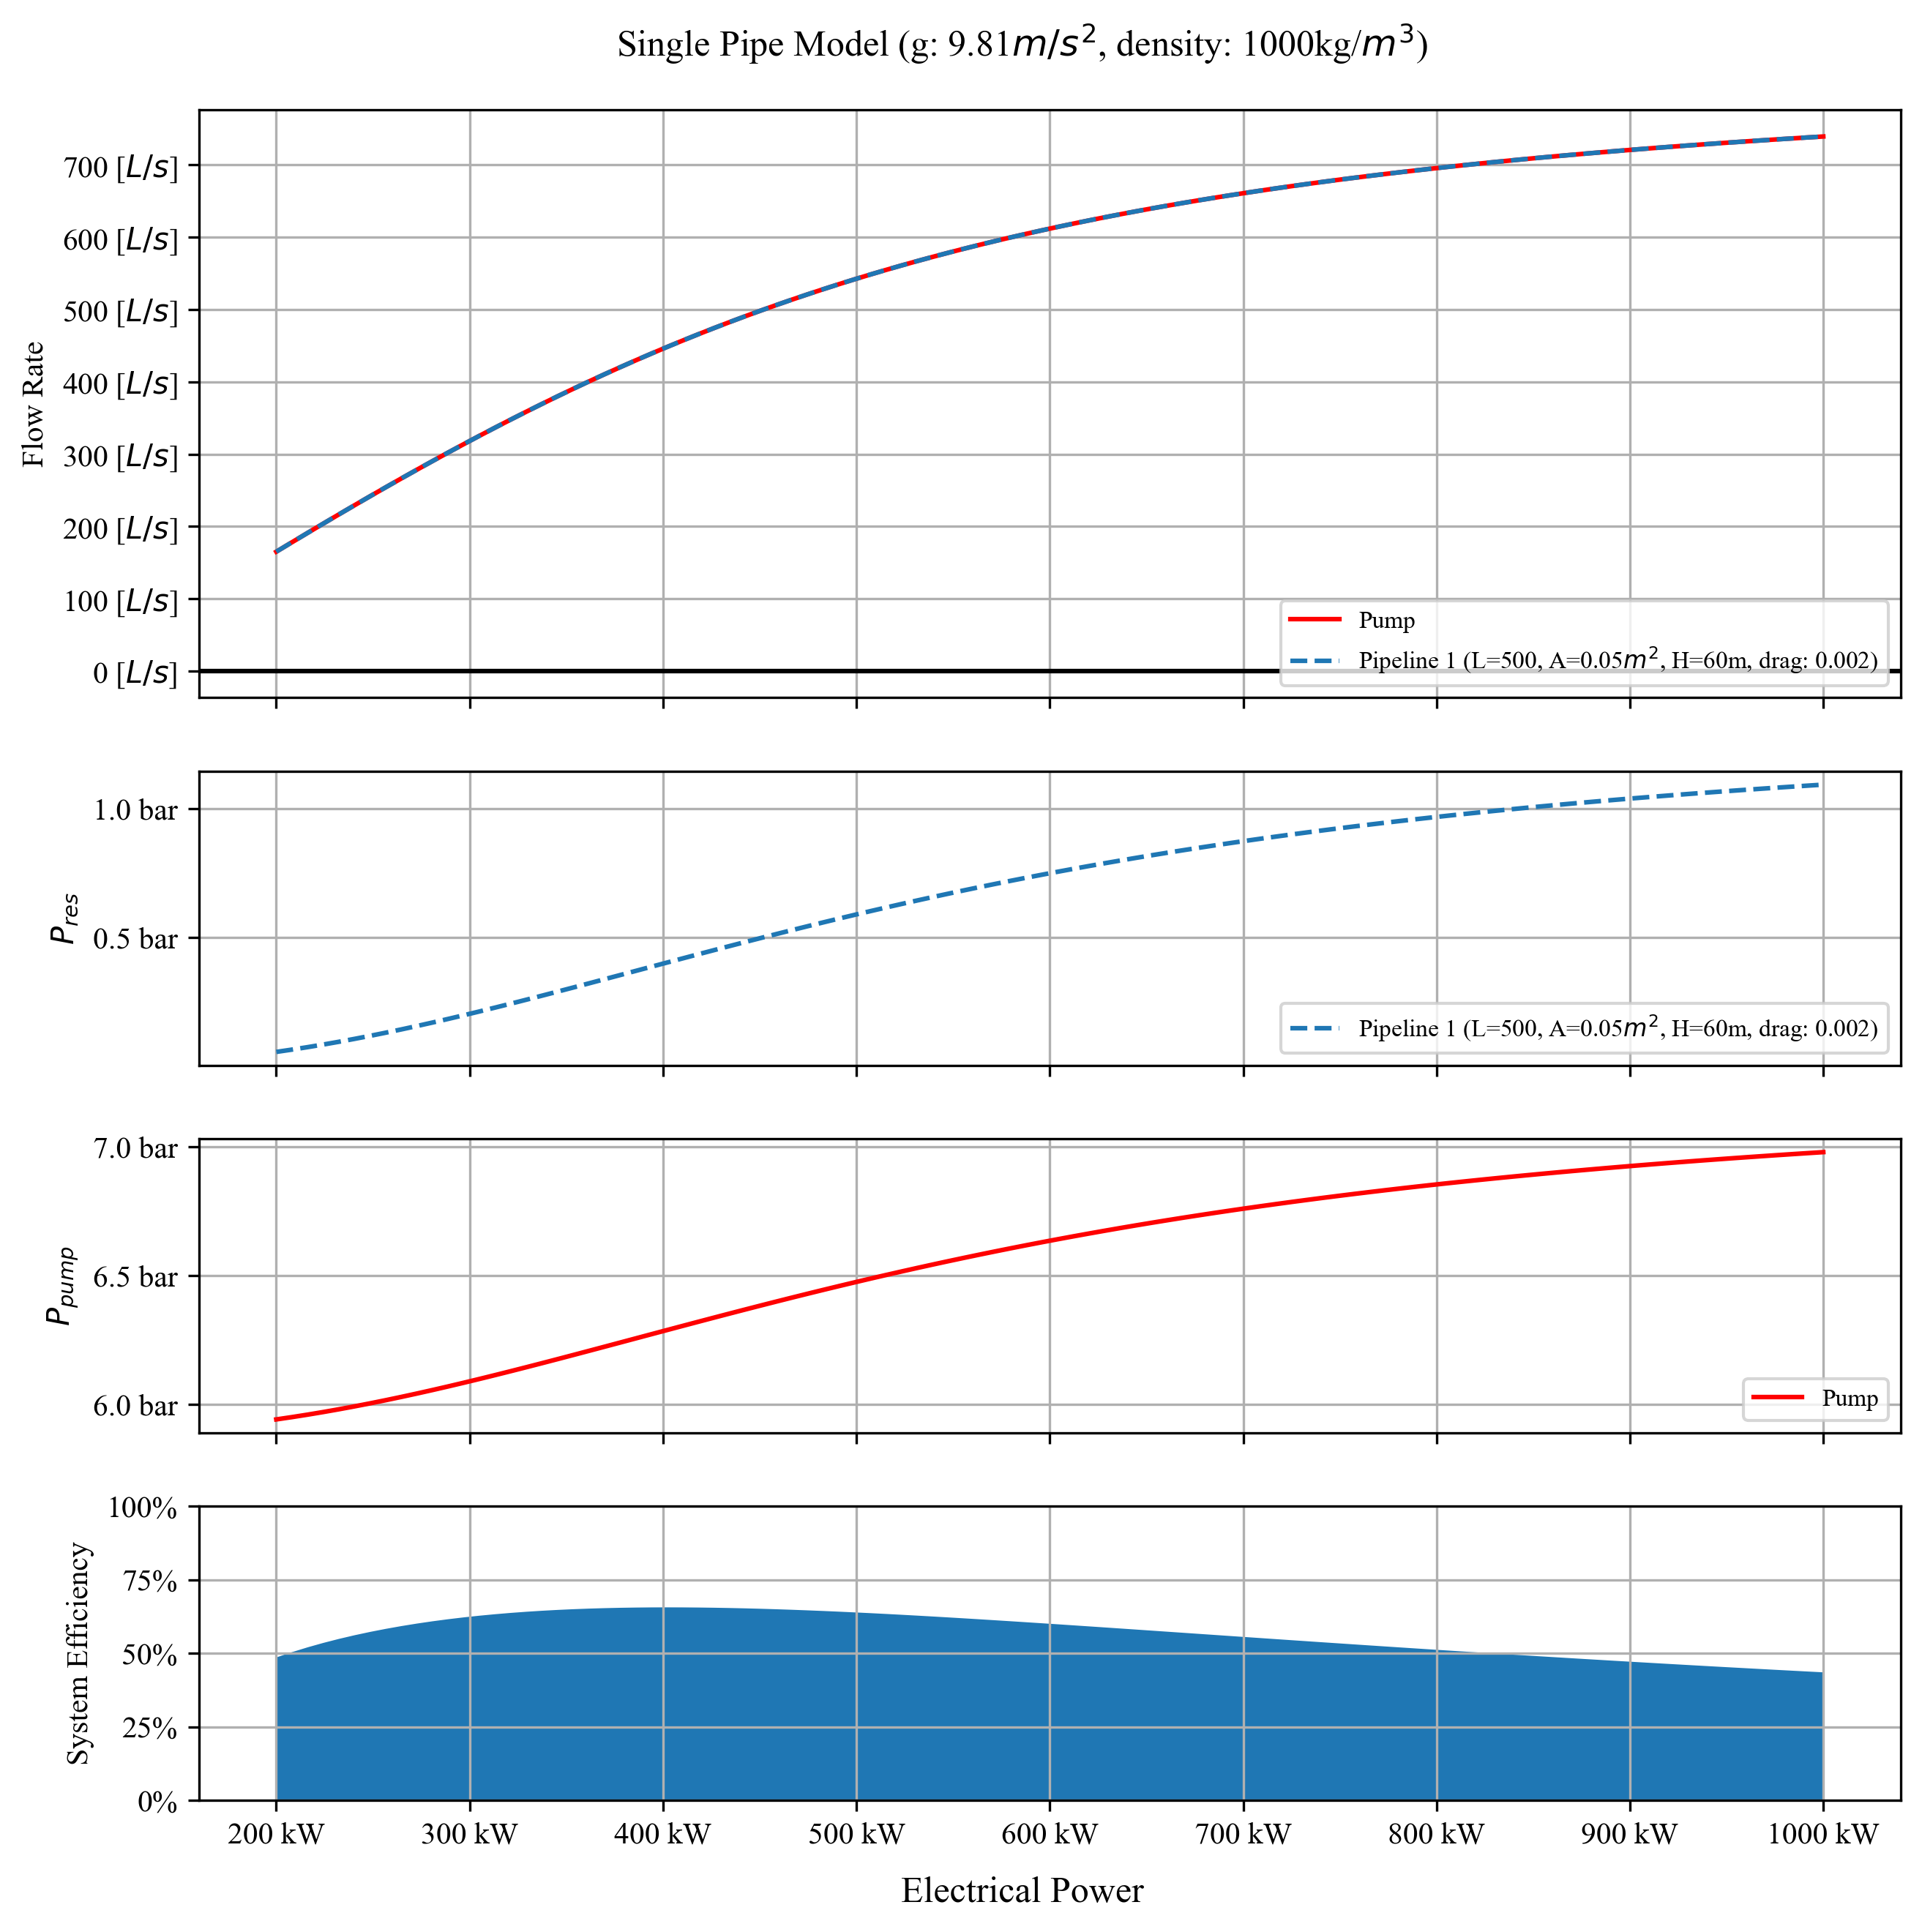

In [15]:
single_pipe_model = get_default_single_pipeline_model()
plot_power_flow_rate_curve(single_pipe_model)

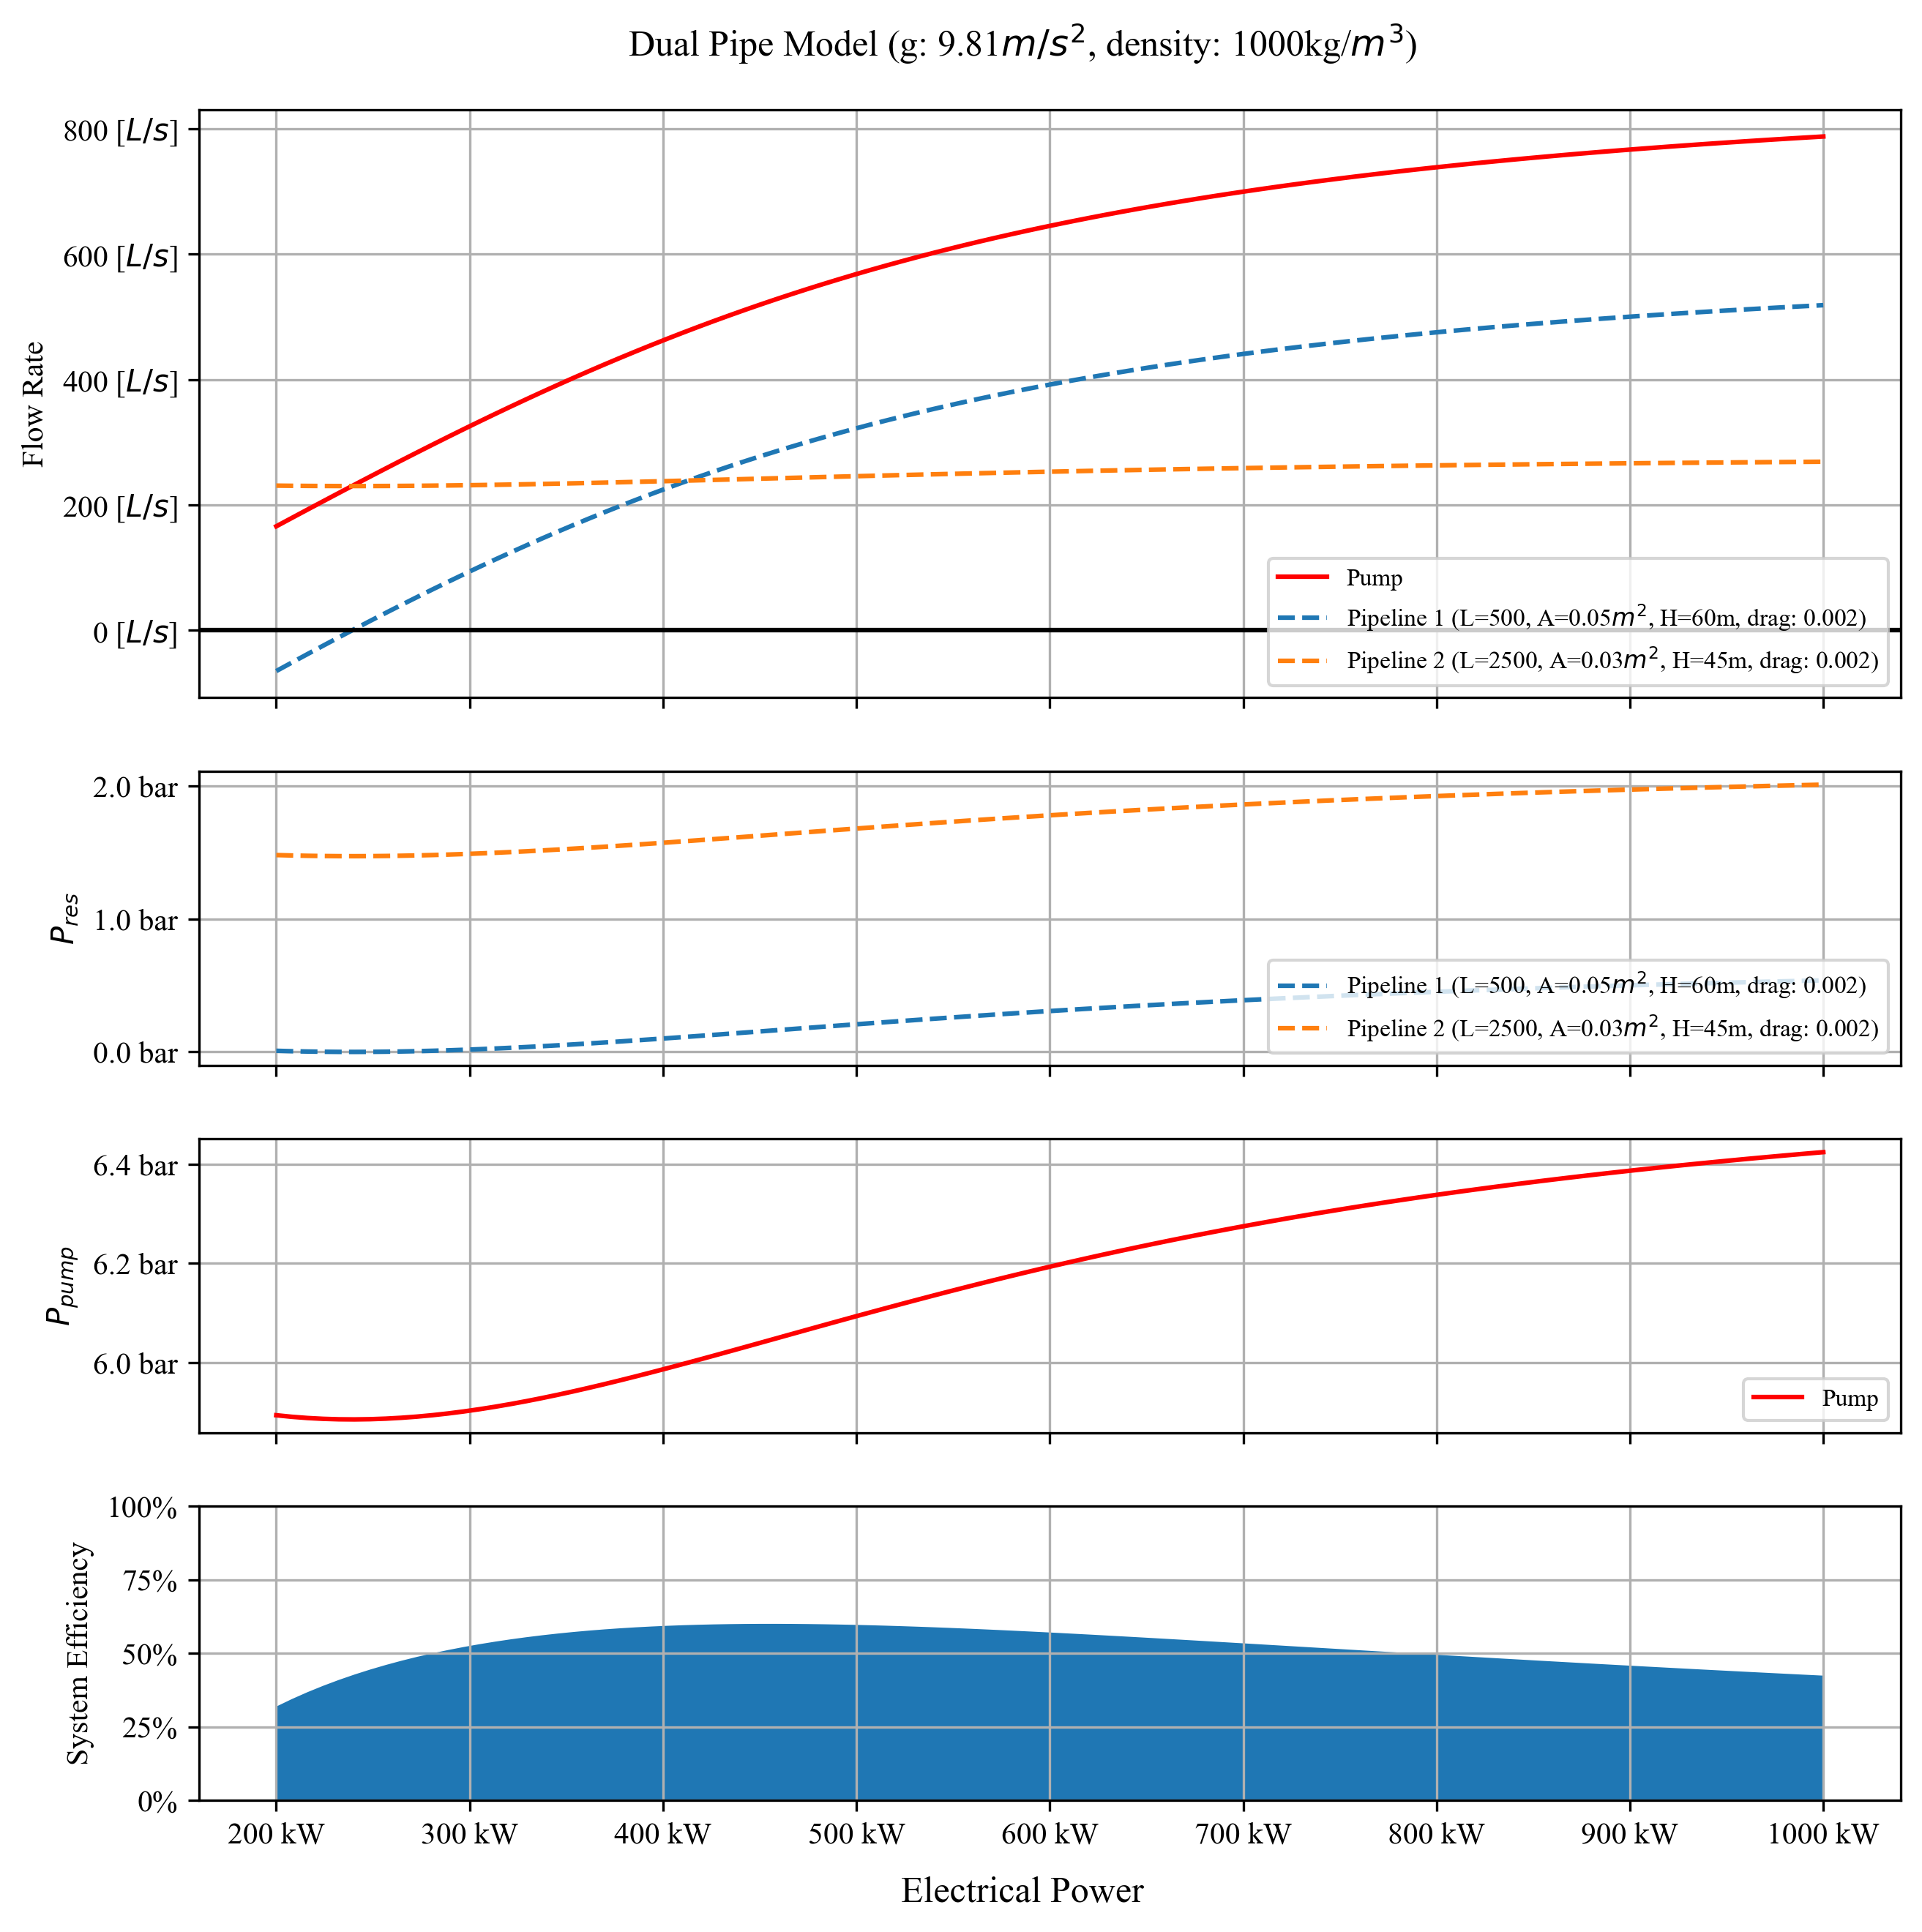

In [16]:
dual_pipe_model = get_default_dual_pipeline_model()
plot_power_flow_rate_curve(dual_pipe_model)

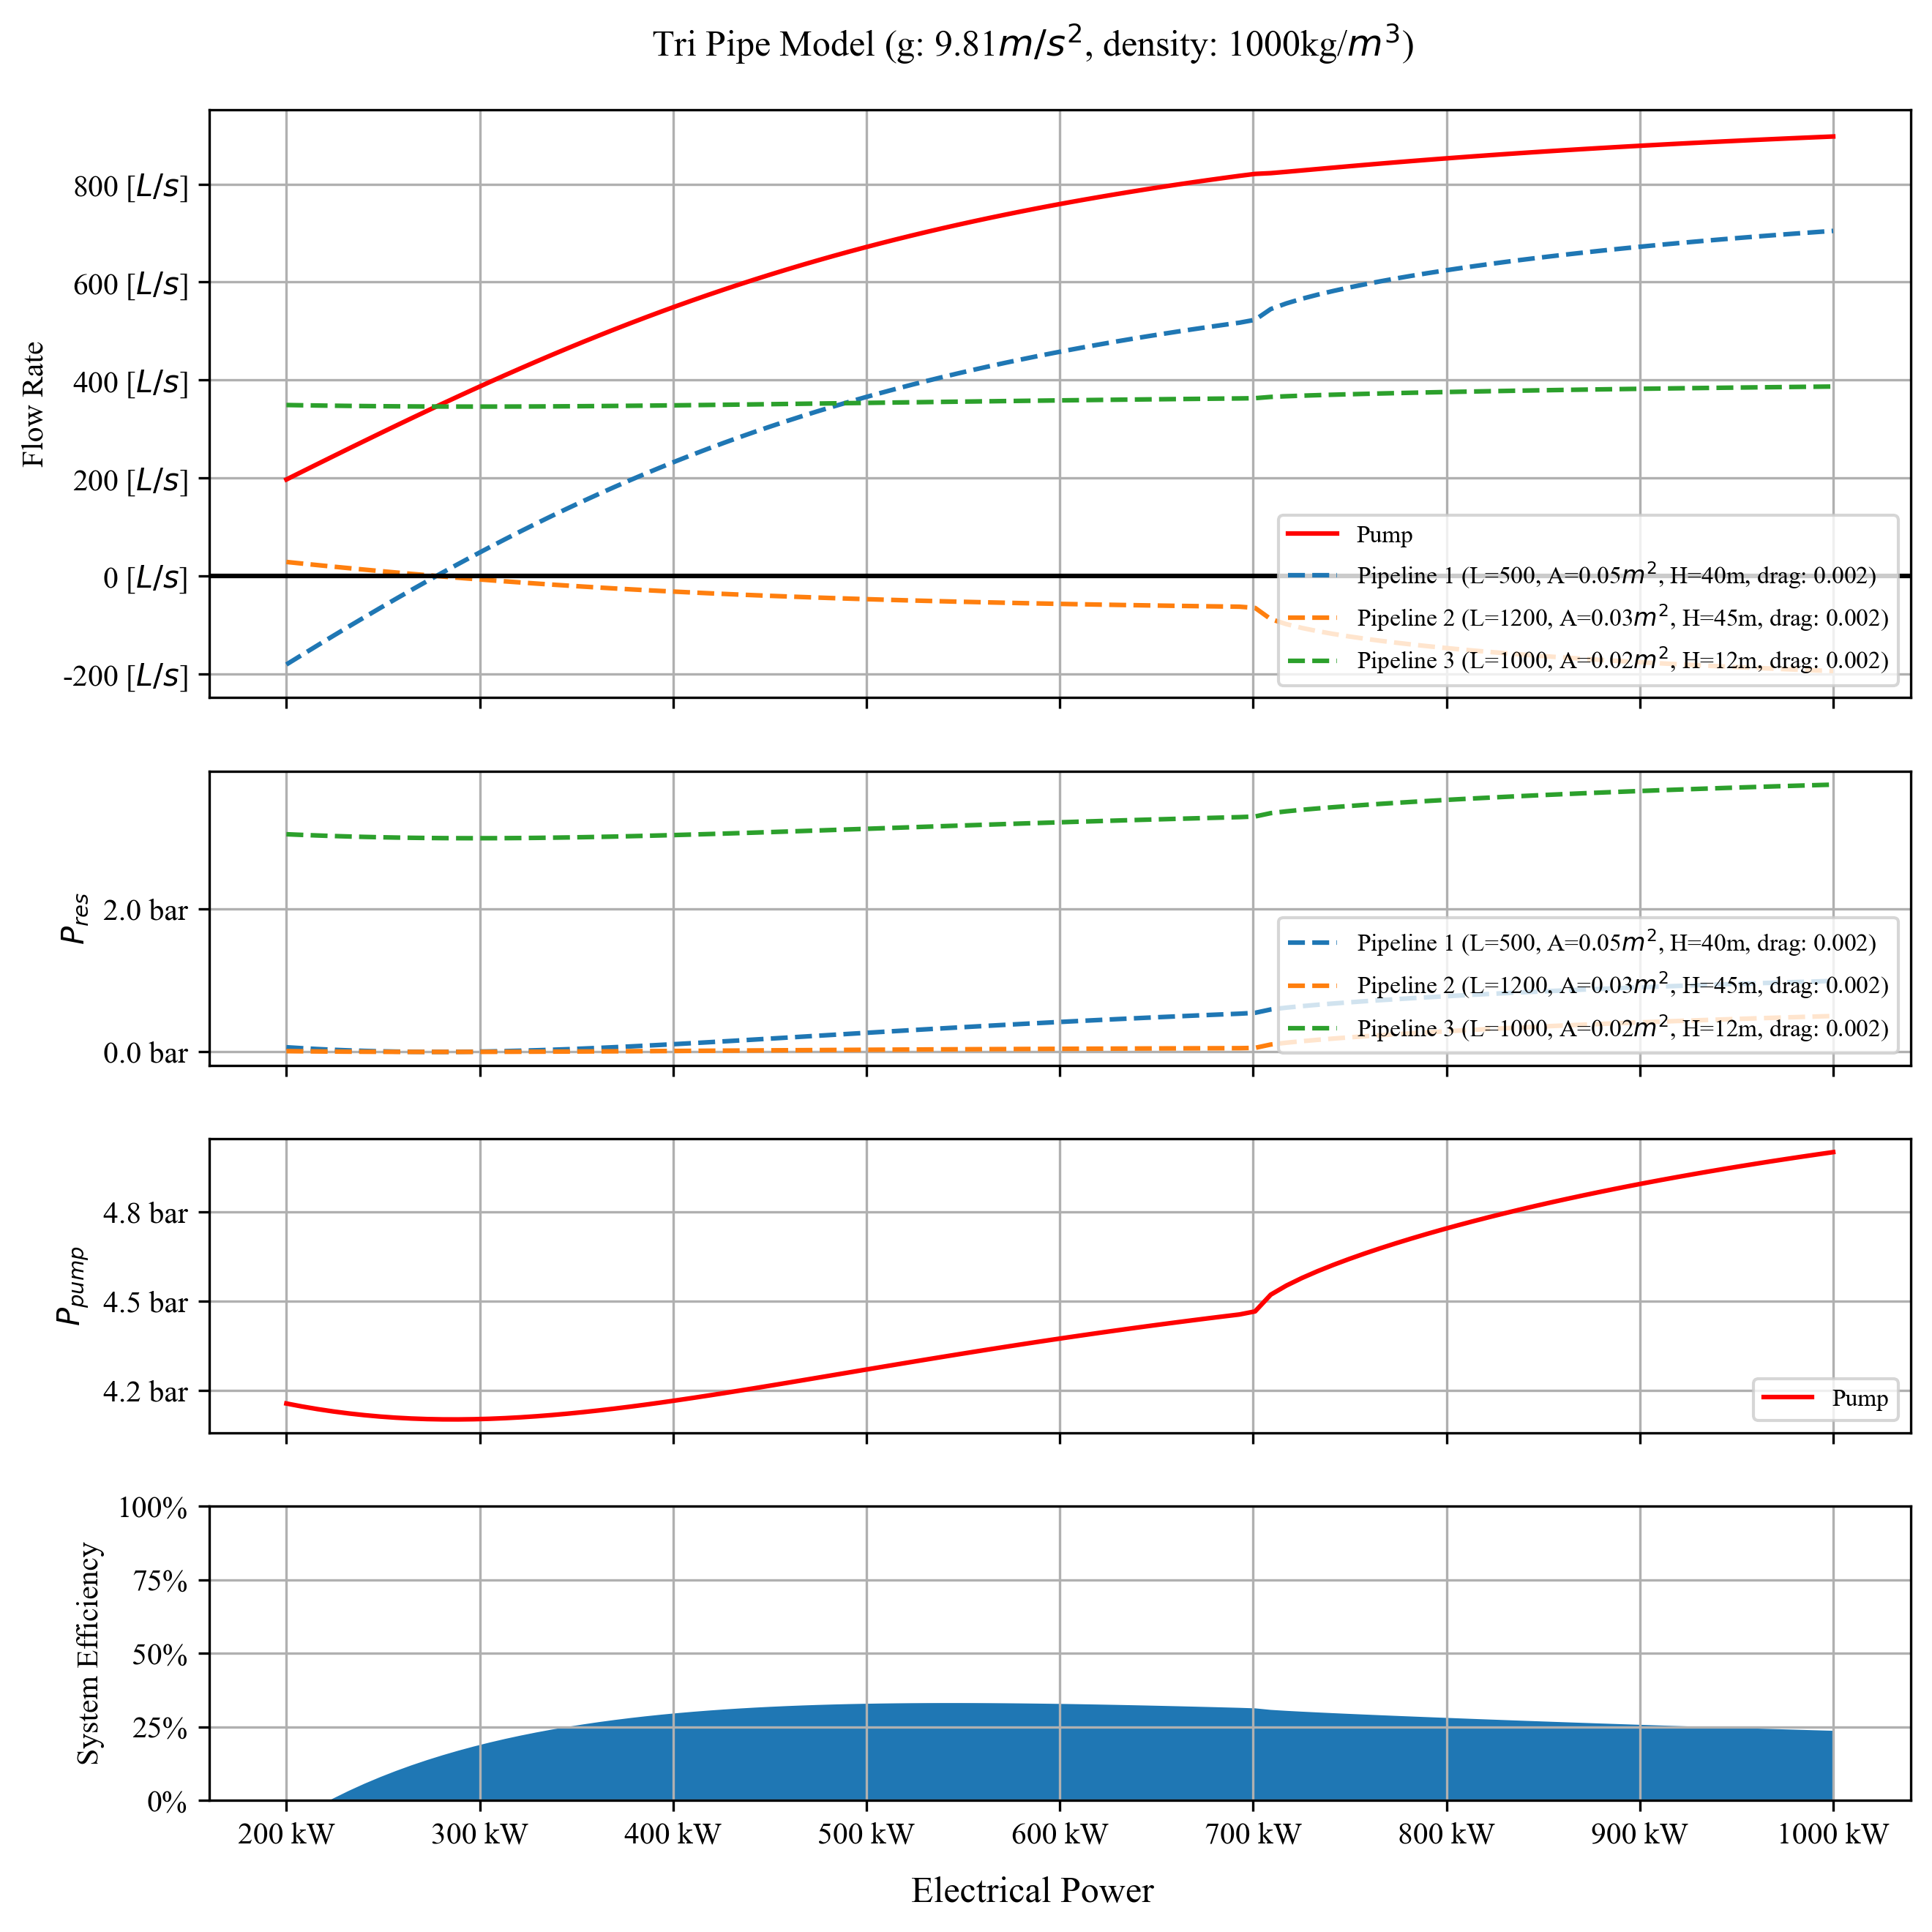

In [17]:
tri_pipe_model = get_default_tri_pipeline_model()
plot_power_flow_rate_curve(tri_pipe_model, method="Nelder-Mead")

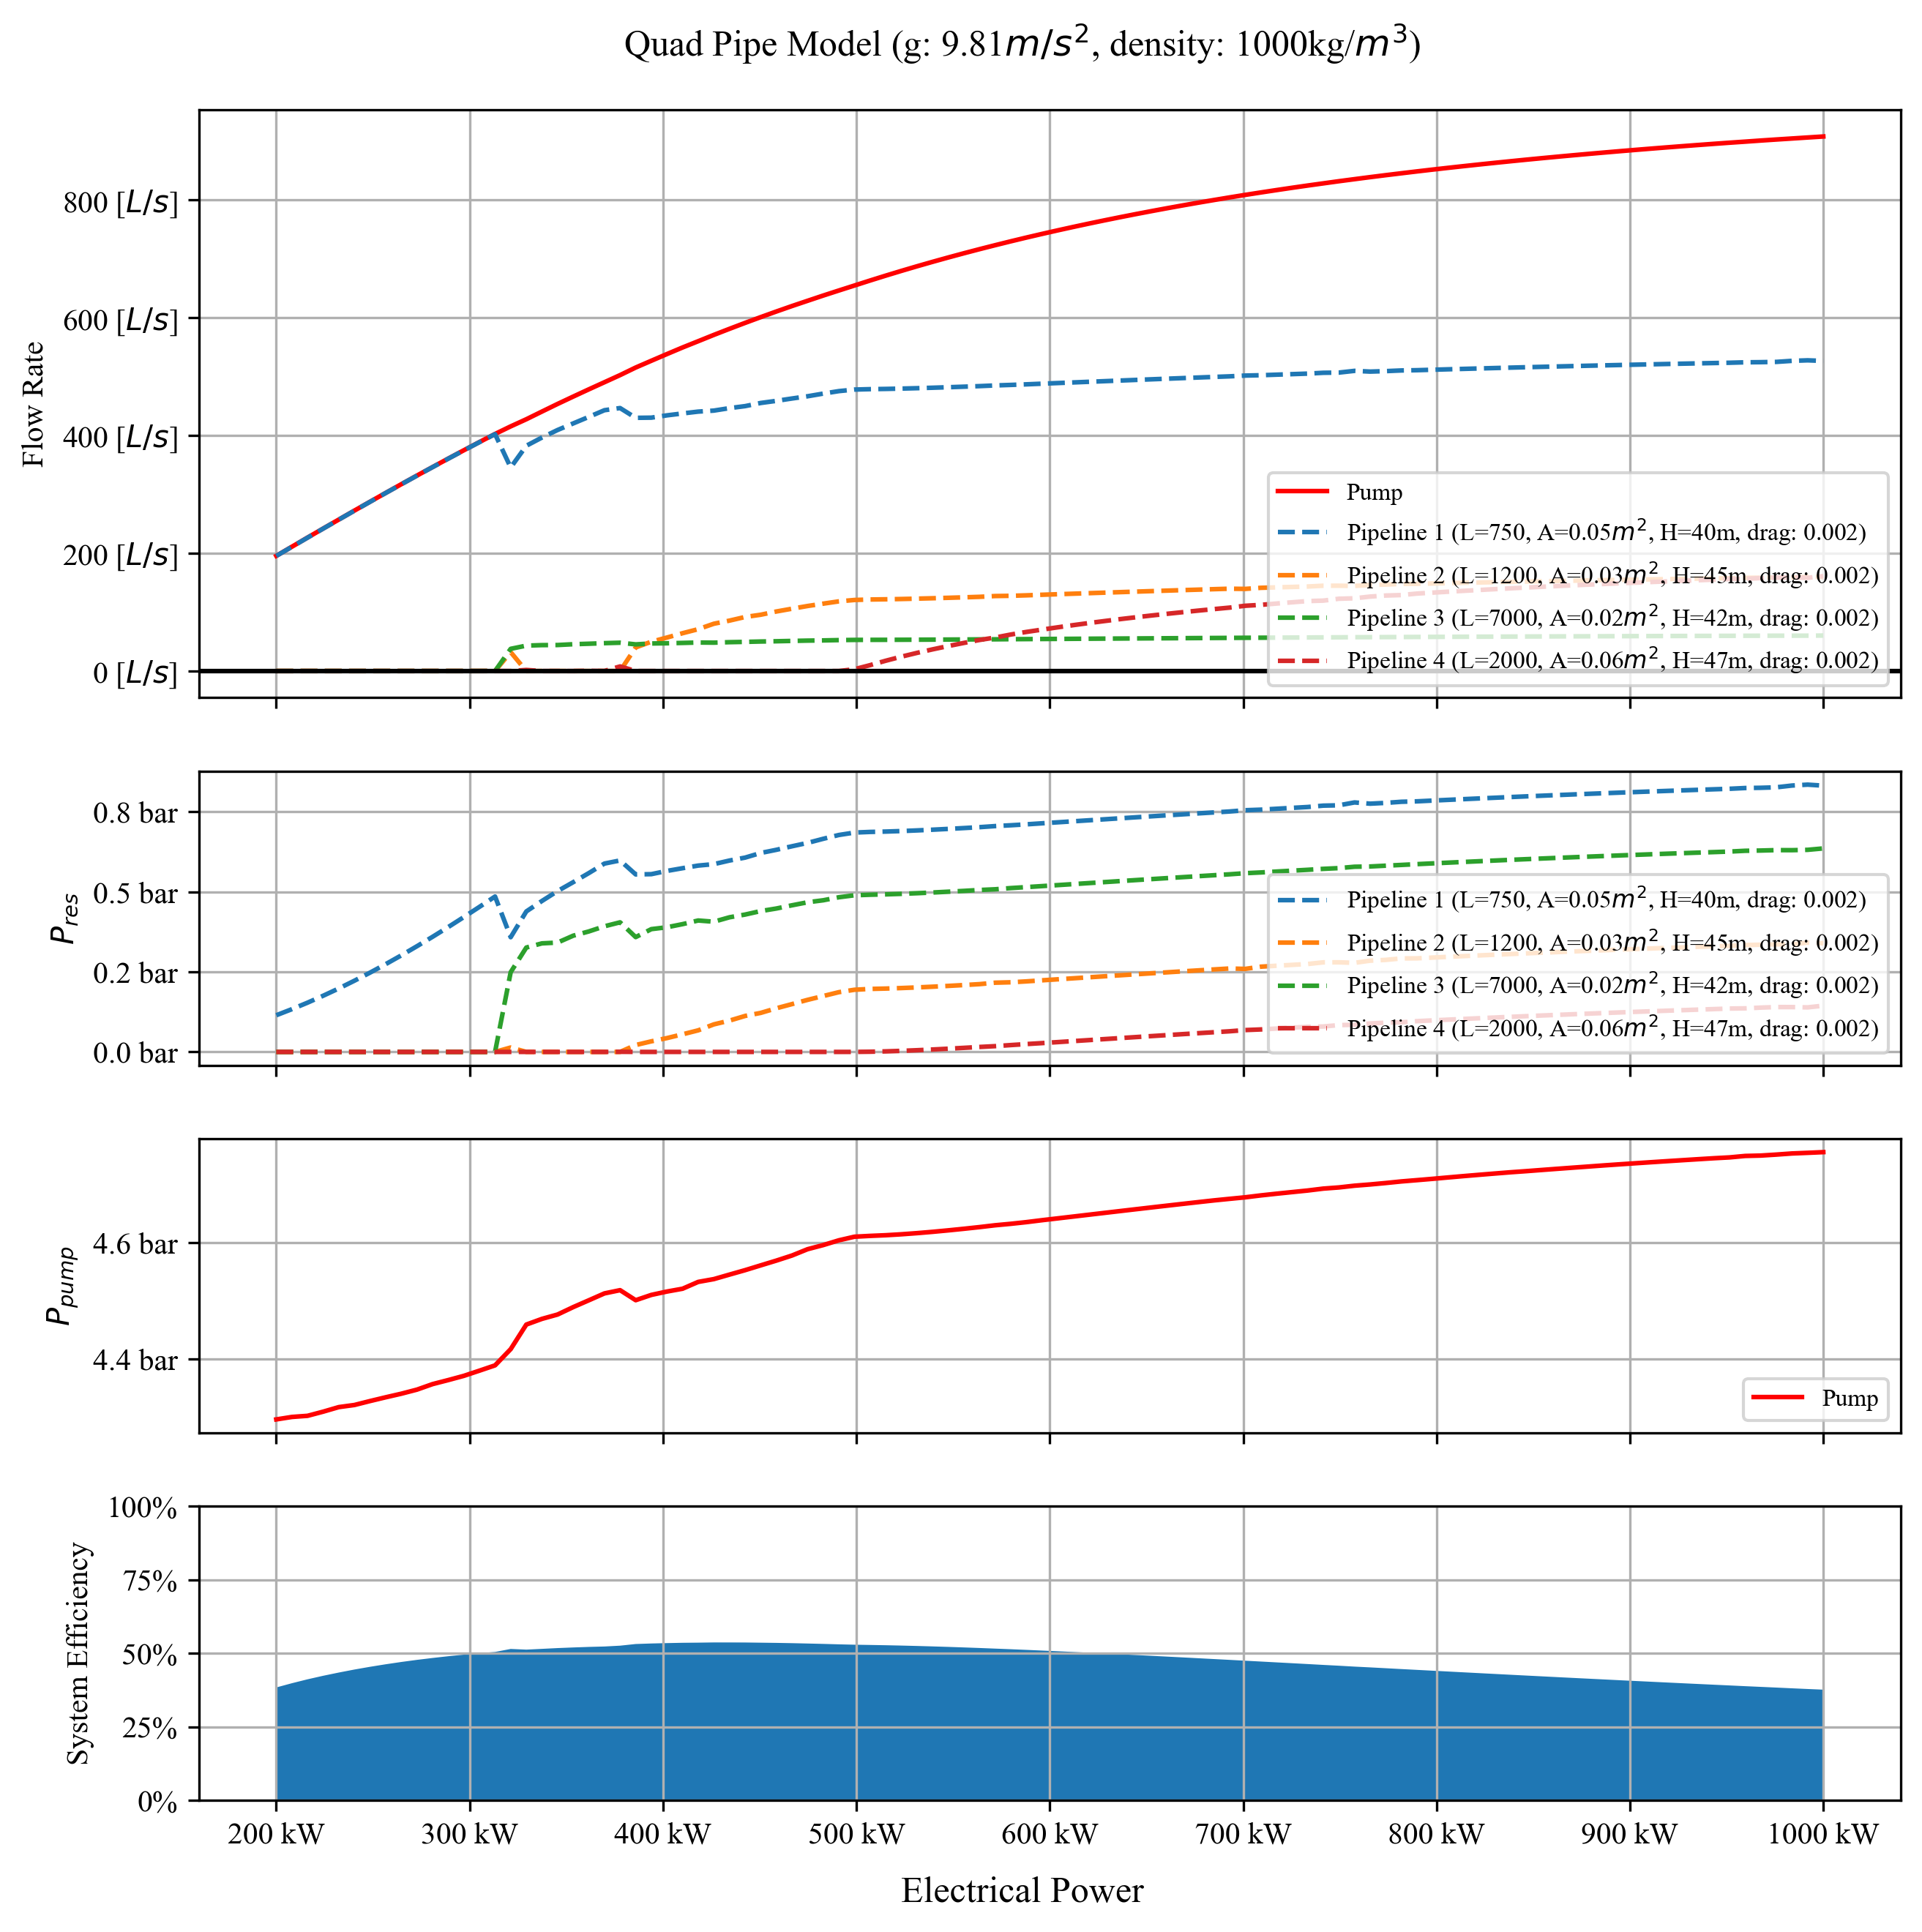

In [18]:
quad_pipe_model = get_default_quad_pipeline_model()
plot_power_flow_rate_curve(quad_pipe_model, method="Powell", bounds=[(0, 1.2), (0, 1.2), (0, 1.2), (0, 1.2)], options=dict(maxiter=10000))